# Basic Fitting Routines
This notebook begins to try and model the background data before any cuts have been applied. It reads in data that has already been put into bins, focused on a region of interest (ROI) and empty bins, such as those in the blinded region, removed. It uses the most basic of fitting/parameter estimation algorithms namely a least-squares and a chi-square approach. Both are available as part of the scipy.optimize package.

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import bgfuncs as bf
import matplotlib.pyplot as plt

## Visualise Data
First we read in all the different data and visualise it to see which bin choice is the best. So far 4 sets exist they are the 100, 200, 300 and 400 bin data.

In [2]:
data = {'100': 0, '200': 0, '300': 0, '400': 0}

for fname in data.keys():
    d = pd.read_csv(f"/home/user211/project/data/{fname}bins.txt")
    # Add _True at the end of the filename for normalised
    data[fname] = d

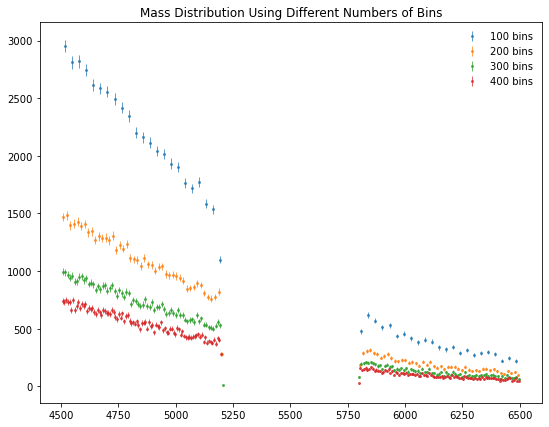

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
for bins, d in data.items():
    ax.errorbar(d['Mass'], d['Frequency'], d['Error'], capsize=0, elinewidth=1, ms=2, fmt='o', label=f'{bins} bins', alpha=0.7)
plt.legend(frameon=False)
plt.title('Mass Distribution Using Different Numbers of Bins')
plt.show()

We have some glitchy points in the middle where we have some fraction of a bin due to the blinded region not aligning with the bin edges. We randomly remove these points.

In [4]:
data['400'] = data['400'].drop([90, 91])
data['300'] = data['300'].drop([68, 69])
data['200'] = data['200'].drop([45, 46])
data['100'] = data['100'].drop([22, 23])

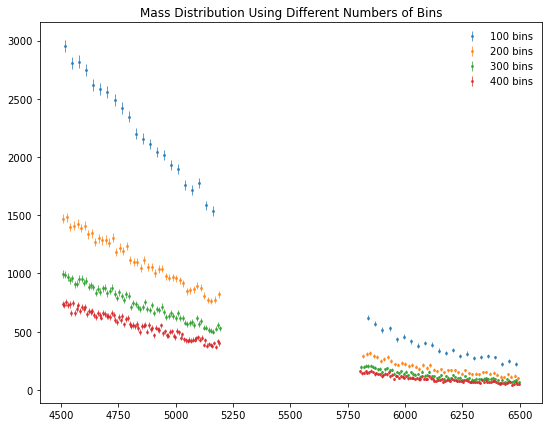

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
for bins, d in data.items():
    ax.errorbar(d['Mass'], d['Frequency'], d['Error'], capsize=0, elinewidth=1, ms=2, fmt='o', label=f'{bins} bins', alpha=0.7)
plt.legend(frameon=False)
plt.title('Mass Distribution Using Different Numbers of Bins')
plt.show()

## Chi-Square Fitting
The chi-square fitting algorithm. Below we implement this algorithm in order to try and fit a variety of functions to these data. We then evaluate some performance metrics such as $\chi^2$ and errors on the fit parameters to establish which fit is best.

In [6]:
funcs = {
    'exponential': bf.exponential, 
    'linear': bf.linear, 
    'quadratic': bf.quadratic, 
    'cubic': bf.cubic, 
    'gaussian': bf.gaussian,
    'expsquare': bf.expsquare
}

In [7]:
from scipy.optimize import curve_fit
test_function = 'expsquare'
# Curve fit can take errors which then performs a standard chi-square minimisation

x, y, yerr = data['200']['Mass'], data['200']['Frequency'], data['200']['Error']
popt, pcov = curve_fit(funcs[test_function], x, y, [1, 1, 1], yerr, absolute_sigma=True)
# Perform the chi-square minimisation

/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


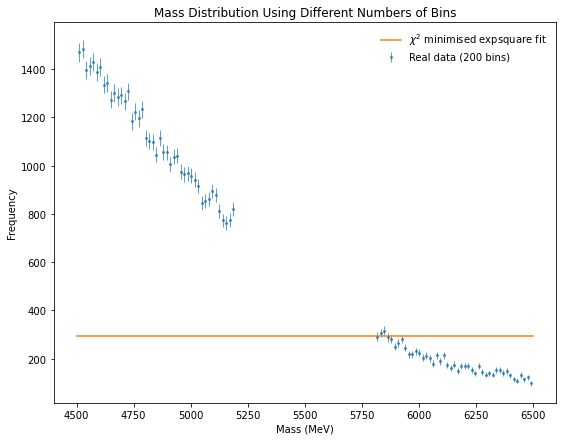

[  1.           1.         295.39373363]


<Figure size 432x288 with 0 Axes>

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
func_x = np.linspace(4500, 6500, 500)
ax.errorbar(x, y, yerr, capsize=0, elinewidth=1, ms=2, fmt='o', label='Real data (200 bins)', alpha=0.7)
ax.plot(func_x, funcs[test_function](func_x, *popt), label=rf'$\chi^2$ minimised {test_function} fit')
ax.set_xlabel('Mass (MeV)')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.title('Mass Distribution Using Different Numbers of Bins')
plt.show()
plt.savefig(f'/home/user211/project/images/{test_function}_chisquare_fit.png')
print(popt)